## Configure tesseract

In [1]:
import pytesseract
print(pytesseract.get_tesseract_version())
pytesseract.pytesseract.tesseract_cmd = r'C:\\Program Files\\Tesseract-OCR\\tesseract.exe'

5.5.0.20241111


# หน้าแรก

In [346]:
import cv2
from matplotlib import table
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from PIL import Image

output_folder = Path("../data/output_images/output_V6_HS_TSR/front")
output_folder.mkdir(exist_ok=True)

#image = Image.open("C:/Users/Impan/Documents/ocr-engine-python/data/test_images/transcript/high_school/moe/transcript_hs_moe_f_1.png")
#image = Image.open("C:/Users/Impan/Documents/ocr-engine-python/data/test_images/transcript/high_school/moe/transcript_hs_moe_f_2.png") # ตารางเส้นจาง
image = Image.open("C:/Users/Impan/Documents/ocr-engine-python/data/test_images/transcript/high_school/moe/transcript_hs_moe_f_3.png") 
#image = Image.open("C:/Users/Impan/Documents/ocr-engine-python/data/test_images/transcript/high_school/moe/transcript_hs_moe_f_5.png") # แตกเพราะปั้ม
#image = Image.open("C:/Users/Impan/Documents/ocr-engine-python/data/test_images/transcript/high_school/moe/transcript_hs_moe_f_6.png") # ซ้ำกับ 5
#image = Image.open("C:/Users/Impan/Documents/ocr-engine-python/data/test_images/transcript/high_school/moe/transcript_hs_moe_f_7.png")
#image = Image.open("C:/Users/Impan/Documents/ocr-engine-python/data/test_images/transcript/high_school/moe/transcript_hs_moe_f_8.png")
#image = Image.open("C:/Users/Impan/Documents/ocr-engine-python/data/test_images/transcript/high_school/moe/transcript_hs_moe_f_9.png") # ทำ gaussian แล้วเส้นขาด
#image = Image.open("C:/Users/Impan/Documents/ocr-engine-python/data/test_images/transcript/high_school/moe/transcript_hs_moe_f_11.png")
#image = Image.open("C:/Users/Impan/Documents/ocr-engine-python/data/test_images/transcript/high_school/moe/transcript_hs_moe_f_14.png")
#image = Image.open("C:/Users/Impan/Documents/ocr-engine-python/data/test_images/transcript/high_school/moe/transcript_hs_moe_f_16.png") # แก้เส้นอาจจะได้
#image = Image.open("C:/Users/Impan/Documents/ocr-engine-python/data/test_images/transcript/high_school/moe/transcript_hs_moe_f_17.png")
#image = Image.open("C:/Users/Impan/Documents/ocr-engine-python/data/test_images/transcript/high_school/moe/transcript_hs_moe_f_18.png") # แก้เส้นอาจจะได้ persective_transformation แตก
#image = Image.open("C:/Users/Impan/Documents/ocr-engine-python/data/test_images/transcript/high_school/moe/transcript_hs_moe_f_19.png")
#image = Image.open("C:/Users/Impan/Documents/ocr-engine-python/data/test_images/transcript/high_school/moe/transcript_hs_moe_f_20.png") # เส้นตารางแนวนอนหาย
#image = Image.open("C:/Users/Impan/Documents/ocr-engine-python/data/test_images/transcript/high_school/moe/transcript_hs_moe_f_21.png") # เส้นตารางไม่ชัด (หนัก)
#image = Image.open("C:/Users/Impan/Documents/ocr-engine-python/data/test_images/transcript/high_school/moe/transcript_hs_moe_f_22.png") # แก้เส้นอาจจะได้ (ไม่ได้)
#image = Image.open("C:/Users/Impan/Documents/ocr-engine-python/data/test_images/transcript/high_school/moe/transcript_hs_moe_f_23.png") 
#image = Image.open("C:/Users/Impan/Documents/ocr-engine-python/data/test_images/transcript/high_school/moe/transcript_hs_moe_f_24.png")
#image = Image.open("C:/Users/Impan/Documents/ocr-engine-python/data/test_images/transcript/high_school/moe/transcript_hs_moe_f_25.png") ### แก้เส้นอาจจะได้
#image = Image.open("C:/Users/Impan/Documents/ocr-engine-python/data/test_images/transcript/high_school/moe/transcript_hs_moe_f_26.png") # เส้นตารางจางมาก
#image = Image.open("C:/Users/Impan/Documents/ocr-engine-python/data/test_images/transcript/high_school/moe/transcript_hs_moe_f_27.png") # แก้เส้นอาจจะได้
#image = Image.open("C:/Users/Impan/Documents/ocr-engine-python/data/test_images/transcript/high_school/moe/transcript_hs_moe_f_28.png") ## line mask
#image = Image.open("C:/Users/Impan/Documents/ocr-engine-python/data/test_images/transcript/high_school/moe/transcript_hs_moe_f_29.png") # แก้เส้นอาจจะได้
#image = Image.open("C:/Users/Impan/Documents/ocr-engine-python/data/test_images/transcript/high_school/moe/transcript_hs_moe_f_30.png") 

if image is None:
    raise FileNotFoundError("ไม่พบไฟล์ภาพ กรุณาตรวจสอบเส้นทางของไฟล์")

new_size = (1660, 2347)  # ตัวอย่างขนาดใหม่
resized_pil = image.resize(new_size, Image.LANCZOS) # ปรับขนาดภาพด้วย LANCZOS filter

# แปลงภาพจาก PIL Image เป็น NumPy array (ในรูปแบบ RGB)
img_rgb = np.array(resized_pil)

# แปลงจาก RGB เป็น BGR เพื่อให้ใช้งานกับ OpenCV ได้
img_cv = cv2.cvtColor(img_rgb, cv2.COLOR_RGB2BGR)

denoised = cv2.bilateralFilter(img_cv, d=9, sigmaColor=75, sigmaSpace=75) # จำกัด noise
gray_img = cv2.cvtColor(denoised, cv2.COLOR_BGR2GRAY)

image_array = np.array(image)


binary_gaussian = cv2.adaptiveThreshold(
    gray_img, 
    maxValue=255, 
    adaptiveMethod=cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
    thresholdType=cv2.THRESH_BINARY_INV, 
    blockSize=51, #51
    C=9 #21 #15
)


# สร้าง kernel สำหรับ morphological operation
kernel = np.ones((3, 3), np.uint8)
dilated = cv2.dilate(binary_gaussian, kernel, iterations=1)
# ใช้ closing เพื่อเติมเต็มส่วนที่ขาดของเส้น
closed_dummy = cv2.morphologyEx(binary_gaussian, cv2.MORPH_CLOSE, kernel, iterations=1)

cv2.imwrite(f"{output_folder}/img_cv.png", img_cv)
cv2.imwrite(f"{output_folder}/image_array.png", image_array)
cv2.imwrite(f"{output_folder}/denoised.png", denoised)
cv2.imwrite(f"{output_folder}/gray.png", gray_img)
cv2.imwrite(f"{output_folder}/binary_g.png", binary_gaussian)
cv2.imwrite(f"{output_folder}/dilated.png", dilated)
cv2.imwrite(f"{output_folder}/closed_dummy.png", closed_dummy)


True

In [347]:
def split_grade_table_and_students(binary_img, denoised, dummy):
    
    # แยกตาราง
    #num_labels, labels, stats, centroids = cv2.connectedComponentsWithStats(binary_img, connectivity=8)
    num_labels, labels, stats, centroids = cv2.connectedComponentsWithStats(dummy, connectivity=8)
    areas = [stat[4] for stat in stats]  # ดึงค่า area
    sorted_areas = sorted(areas, reverse=True)  # เรียงลำดับจากมากไปน้อย
    second_max_area = sorted_areas[1]  # ค่าอันดับ 2
    second_max_area_index = areas.index(second_max_area)  # หาตำแหน่งในลิสต์เดิม
    table_position = stats[second_max_area_index]
    x, y, w, h, area = table_position

    table_img = binary_img[y:y+h, x:x+w]
    table_dummy_img = dummy[y:y+h, x:x+w]
    table_original_img = denoised[y:y+h, x:x+w]

    '''
    table_img = binary_img[y:y+h, :]
    table_dummy_img = dummy[y:y+h, :]
    table_original_img = denoised[y:y+h, :]

    kernel = np.ones((4, 4), np.uint8)
    closed_table_dummy = cv2.morphologyEx(table_dummy_img, cv2.MORPH_CLOSE, kernel, iterations=2)
    '''

    # ข้อมูลนักเรียน
    #x_start = int((x+w) * 0.40) # ความกว้าง 40% ของตาราง
    x_end = int((x+w) * 0.76) # ความกว้าง 76% ของตาราง
    x_split_half = int((x+w) * 0.53) # ความกว้าง 53% ของตาราง

    student_info_img = binary_img[:y, :x_end]
    student_info_fh_img = binary_img[:y, :x_split_half] # ครึ่งแรก
    student_info_sh_img = binary_img[:y, x_split_half:x_end] # ครึ่งหลัง

    #student_info_sh_img = binary_img[:y, x_split_half:x_end] # ครึ่งหลัง

    return table_img, table_dummy_img, table_original_img, student_info_img, student_info_fh_img, student_info_sh_img,
    #return table_img, closed_table_dummy, table_original_img, student_info_img, student_info_fh_img, student_info_sh_img, 

def biggest_contour(contours):
    biggest = np.array([])
    max_area = 0
    for i in contours:
        area = cv2.contourArea(i)
        #print(area)
        if area > 1000:
            #print("มา")
            peri = cv2.arcLength(i, True)
            approx = cv2.approxPolyDP(i, 0.02 * peri, True)
            if area > max_area and len(approx) == 4:
                biggest = approx
                max_area = area

    return biggest

def persective_transformation(table_binary_img, table_original_img, table_dummy_img):

    # ค้นหาคอนทัวร์
    contours, hierarchy = cv2.findContours(table_dummy_img, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    #contours, hierarchy = cv2.findContours(table_binary_img, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    contours = sorted(contours, key=cv2.contourArea, reverse=True)[:10]

    # ค้นหาสี่เหลี่ยมที่ใหญ่ที่สุด
    biggest = biggest_contour(contours)

    points = biggest.reshape(4, 2)
    input_points = np.zeros((4, 2), dtype="float32")

    points_sum = points.sum(axis=1)
    input_points[0] = points[np.argmin(points_sum)]
    input_points[3] = points[np.argmax(points_sum)]

    points_diff = np.diff(points, axis=1)
    input_points[1] = points[np.argmin(points_diff)]
    input_points[2] = points[np.argmax(points_diff)]

    (top_left, top_right, bottom_right, bottom_left) = input_points

    # Euclidean Distance Formula
    bottom_width = np.sqrt(((bottom_right[0] - bottom_left[0]) ** 2) + ((bottom_right[1] - bottom_left[1]) ** 2))
    top_width = np.sqrt(((top_right[0] - top_left[0]) ** 2) + ((top_right[1] - top_left[1]) ** 2))
    rigth_height = np.sqrt(((top_left[0] - bottom_right[0]) ** 2) + ((top_left[1] - bottom_right[1]) ** 2))
    left_height = np.sqrt(((top_left[0] - bottom_left[0]) ** 2) + ((top_left[1] - bottom_left[1]) ** 2))

    # Output image size
    #max_width = max(int(bottom_width), int(top_width))
    expand_width = round(max(int(bottom_width), int(top_width)) * 0.4)
    max_width = max(int(bottom_width), int(top_width)) + expand_width
    max_height = max(int(rigth_height), int(left_height))

    # Desird points values in the output image
    converted_points = np.float32([[0, 0], [max_width, 0], [0, max_height], [max_width, max_height]])

    # Perspective transformaxtion
    matrix = cv2.getPerspectiveTransform(input_points, converted_points)
    img_out = cv2.warpPerspective(table_binary_img.copy(), matrix, (max_width, max_height))
    img_original_out = cv2.warpPerspective(table_original_img.copy(), matrix, (max_width, max_height))
    img_dummy_out = cv2.warpPerspective(table_dummy_img.copy(), matrix, (max_width, max_height))

    #return img_out, img_original_out
    return img_out, img_original_out, img_dummy_out

def create_grid_image(table_img,
                      col_percentages=[25.6, 29, 32.7, 58.3, 61.7, 64.9, 91, 95, 99.8],
                      row_percentages=[4.9, 99.8],
                      grid_color=(255, 255, 255),
                      vertical_line_thickness_percent=0.002,   # 0.33% ของความกว้างภาพสำหรับเส้นแนวตั้ง
                      horizontal_line_thickness_percent=0.002, # 0.33% ของความกว้างภาพสำหรับเส้นแนวนอน
                      bg_color=(0, 0, 0),
                      return_binary=True,
                      threshold_val=127):
    
    """
    สร้างภาพตารางที่มีขนาด width x height โดยแบ่งคอลัมน์และแถวตามเปอร์เซ็นต์ที่กำหนด
    ความหนาของเส้นจะถูกคำนวณเป็นเปอร์เซ็นต์ของความกว้างของภาพ
    ถ้า return_binary=True จะทำการแปลงภาพเป็น binary (ขาวดำ) โดยใช้ threshold ที่กำหนด

    :param width: ความกว้างของภาพ (พิกเซล)
    :param height: ความสูงของภาพ (พิกเซล)
    :param col_percentages: รายการเปอร์เซ็นต์สำหรับขอบขวาของแต่ละคอลัมน์ (เรียงจากน้อยไปมาก; คอลัมน์สุดท้าย = 100%)
    :param row_percentages: รายการเปอร์เซ็นต์สำหรับขอบล่างของแต่ละแถว (เรียงจากน้อยไปมาก; แถวสุดท้าย = 100%)
    :param grid_color: สีของเส้นตารางในรูปแบบ (B, G, R)
    :param line_thickness_percent: ความหนาของเส้นในรูปแบบเปอร์เซ็นต์ของความกว้างภาพ
    :param bg_color: สีพื้นหลังของภาพ
    :param return_binary: ถ้า True จะคืนภาพในรูปแบบ binary (หลัง threshold) มิฉะนั้นคืนค่าเป็น BGR image
    :param threshold_val: ค่าที่ใช้ threshold เมื่อแปลงเป็นภาพ binary
    :return: ภาพตารางในรูปแบบ binary (ถ้า return_binary=True) หรือ BGR image (ถ้า False)
    """

    height, width, = table_img.shape  # ได้ค่า (สูง, กว้าง)

    image = np.full((height, width, 3), bg_color, dtype=np.uint8)
    
    # คำนวณความหนาของเส้นสำหรับแต่ละแนว (อย่างน้อย 1 พิกเซล)
    vertical_thickness = max(1, int(width * vertical_line_thickness_percent))
    horizontal_thickness = max(1, int(width * horizontal_line_thickness_percent))
    
    # คำนวณตำแหน่งเส้นแนวตั้ง (x_positions)
    col_fracs = [p / 100.0 for p in col_percentages]
    x_positions = [0] + [int(width * p) for p in col_fracs]
    
    # คำนวณตำแหน่งเส้นแนวนอน (y_positions)
    row_fracs = [p / 100.0 for p in row_percentages]
    y_positions = [0] + [int(height * p) for p in row_fracs]
    
    # วาดเส้นตารางแนวตั้งโดยใช้ความหนาที่คำนวณสำหรับแนวตั้ง
    for x in x_positions:
        cv2.line(image, (x, 0), (x, height), grid_color, vertical_thickness)
    
    # วาดเส้นตารางแนวนอนโดยใช้ความหนาที่คำนวณสำหรับแนวนอน
    for y in y_positions:
        cv2.line(image, (0, y), (width, y), grid_color, horizontal_thickness)
    
    # แปลงภาพเป็น binary หากต้องการ
    if return_binary:
        # แปลงเป็น grayscale
        gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        # ใช้ threshold เพื่อแปลงเป็นภาพ binary
        _, binary_image = cv2.threshold(gray, threshold_val, 255, cv2.THRESH_BINARY)
        return binary_image
    else:
        return image

def hough_line_transform(binary_image, table_original_persective_img, grid_img):

    # 1) ใช้ HoughLinesP ตรวจจับเส้น
    #    - พารามิเตอร์ที่สำคัญ: threshold, minLineLength, maxLineGap
    lines = cv2.HoughLinesP(
        binary_image,
        rho=1,
        theta=np.pi/180,
        threshold=100,      # ต้องปรับจูน
        minLineLength=500,  # ต้องปรับจูน
        maxLineGap=10    # ต้องปรับจูน
    )

    # 2) สร้าง mask (เป็นภาพดำล้วน ขนาดเท่ากับต้นฉบับ)
    line_mask = np.zeros_like(binary_image)

    if lines is not None:
        for line in lines:
            x1, y1, x2, y2 = line[0]
            # วาดเส้นสีขาวลงใน mask (ปรับ thickness ตามความหนาเส้นในภาพ)
            cv2.line(line_mask, (x1, y1), (x2, y2), 255, 1)

    # 4) เราจะเอา mask นี้มาช่วยลบเส้นในภาพ
    #    วิธีง่าย ๆ คือการเอา thresh ที่เป็น binary_inv มาลบด้วย mask (bitwise)
    #    หรืออาจใช้เทคนิค inpaint บนภาพสี

    # วิธีที่ 4.1: ลบตรง ๆ จาก thresh ก่อน (ซึ่งเป็น Binary แล้ว)
    table_without_lines = cv2.bitwise_and(binary_image, cv2.bitwise_not(line_mask))
    table_without_lines_2 = cv2.bitwise_and(table_without_lines, cv2.bitwise_not(grid_img))
    table_without_lines_3 = cv2.bitwise_and(binary_image, cv2.bitwise_not(grid_img))

    # หรือ วิธีที่ 4.2: ลอง inpaint บนภาพจริงสี (img)
    #    โดยปกติ inpaint จะต้องการ mask สีขาว บริเวณที่ต้องการซ่อมแซม
    #    ซึ่ง line_mask ของเราพอดีอยู่แล้ว
    inpainted = cv2.inpaint(table_original_persective_img, line_mask, 3, cv2.INPAINT_TELEA)

    #kernel = np.ones((20, 15), np.uint8)
    #final_dilate = cv2.dilate(image_without_lines, kernel, iterations=1)


    # เนื่องจาก thresh เป็น invert (พื้นดำ ตัวหนังสือขาว)
    # ถ้าอยากกลับด้านให้พื้นขาว ตัวหนังสือดำก็ทำ bitwise_not อีกที
    #final = cv2.bitwise_not(image_without_lines)
    cv2.imwrite(f"{output_folder}/line_mask.png", line_mask)
    cv2.imwrite(f"{output_folder}/image_without_lines.png", table_without_lines)
    cv2.imwrite(f"{output_folder}/image_without_lines_2.png", table_without_lines_2)
    cv2.imwrite(f"{output_folder}/table_without_lines_3.png", table_without_lines_3)
    #cv2.imwrite(f"{output_folder}/final_dilate.png", final_dilate)
    cv2.imwrite(f"{output_folder}/inpainted.png", inpainted)

    return line_mask, table_without_lines, table_without_lines_2

#table_img, student_info_img, student_info_fh_img, student_info_sh_img, table_original_img = split_grade_table_and_students(binary_gaussian, denoised)
table_img, table_dummy_img, table_original_img, student_info_img, student_info_fh_img, student_info_sh_img = split_grade_table_and_students(binary_gaussian, denoised, dilated)
table_persective_img, table_original_persective_img, table_dummy_persective_img = persective_transformation(binary_gaussian, denoised, dilated)
#table_persective_img, table_original_persective_img, table_dummy_persective_img = persective_transformation(table_img, table_original_img, table_dummy_img)
#grid_img = create_grid_image(table_persective_img)
#line_mask, table_without_lines, table_without_lines_2 = hough_line_transform(table_persective_img, table_original_persective_img, grid_img)

cv2.imwrite(f"{output_folder}/table_img.png", table_img)
cv2.imwrite(f"{output_folder}/table_dummy_img.png", table_dummy_img)
cv2.imwrite(f"{output_folder}/table_original_img.png", table_original_img)
cv2.imwrite(f"{output_folder}/student_info_img.png", student_info_img)
cv2.imwrite(f"{output_folder}/student_info_fh_img.png", student_info_fh_img)
cv2.imwrite(f"{output_folder}/student_info_sh_img.png", student_info_sh_img)

cv2.imwrite(f"{output_folder}/table_persective_img.png", table_persective_img)
cv2.imwrite(f"{output_folder}/table_original_persective_img.png", table_original_persective_img)
cv2.imwrite(f"{output_folder}/table_dummy_persective_img.png", table_dummy_persective_img)


#cv2.imwrite(f"{output_folder}/grid_img.png", grid_img)

True

## ตารางเกรด

### หา column ของตาราง

In [354]:
# ฟังก์ชันสำหรับรวมกลุ่ม indices ที่ติดกันเข้าด้วยกัน
def group_indices(indices, gap=1):
    groups = []
    if not indices:
        return groups
    current = [indices[0]]
    for idx in indices[1:]:
        if idx - current[-1] <= gap:
            current.append(idx)
        else:
            groups.append(current)
            current = [idx]
    groups.append(current)
    return groups

def find_table_columns(table_dummy_persective_img, table_persective_img):

    # คำนวณ horizontal projection (ผลรวมของ pixel ในแต่ละแถว)
    vertical_proj = np.sum(table_dummy_persective_img, axis=0)

    # ตั้ง threshold สำหรับเลือกเฉพาะลอลัมที่มี "เส้น"
    vertical_line_threshold = np.max(vertical_proj) * 0.7

    # หา indices ของแถวที่มีค่า projection มากกว่าค่า threshold
    col_line_indices = [i for i, value in enumerate(vertical_proj) if value > vertical_line_threshold]

    # รวมกลุ่ม indices ที่ติดกัน
    groups_col = group_indices(col_line_indices, gap=1)

    # สำหรับแต่ละกลุ่ม หา index กลางเป็นตำแหน่งของเส้น
    # แต่แทนที่จะใช้ความหนาแน่น เราจะใช้ความยาวของแต่ละกลุ่ม (จำนวน index ในกลุ่ม)
    groups_col_with_length = [(group, len(group)) for group in groups_col]

    # เรียงลำดับกลุ่มจากความยาวมากไปหาน้อย
    groups_col_with_length.sort(key=lambda x: x[1], reverse=True)

    # เลือกเฉพาะกลุ่มที่มีความยาวมากที่สุด
    top_groups_col = groups_col_with_length[:10]

    # คำนวณตำแหน่งเส้นโดยการหาค่าเฉลี่ยของแต่ละกลุ่ม แล้วเรียงลำดับ
    col_lines = [int(np.mean(group)) for group, _ in top_groups_col]
    col_lines.sort()

    print("ตำแหน่งของเส้นคอลัมน์ที่ตรวจจับได้:", col_lines)
    mask_col = np.zeros_like(table_dummy_persective_img)

    # วาดเส้นคอลัมน์ลงใน mask (เส้นแนวตั้ง)
    for x in col_lines:
        cv2.line(mask_col, (x, 0), (x, mask_col.shape[0]-1), 255, thickness=10)
    cv2.imwrite(f"{output_folder}/cols/col_lines_mask.png", mask_col)

    # --- ใช้ cv2.bitwise_and เพื่อลบเส้นแถวออกจากภาพ ---
    mask_col_inv = cv2.bitwise_not(mask_col)
    img_no_lines_col = cv2.bitwise_and(table_persective_img, table_persective_img, mask=mask_col_inv)
    cv2.imwrite(f"{output_folder}/cols/table_no_lines_bitwise_col.png", img_no_lines_col)

    cropped_col_segments = []

    for i in range(len(col_lines) - 1):
        x_start = col_lines[i]
        x_end = col_lines[i+1]
        cropped = img_no_lines_col[:, x_start:x_end]  # crop ทุกคอลัมน์ในช่วงแถวที่กำหนด
        cropped_col_segments.append(cropped)
        cv2.imwrite(f"{output_folder}/cols/cropped_segment_{i+1}.png", cropped)

    return cropped_col_segments

    '''
    # คำนวณ vertical projection (ผลรวมของ pixel ในแต่ละคอลัมน์)
    vertical_proj = np.sum(table_dummy_persective_img, axis=0)

    # ตั้ง threshold สำหรับเลือกเฉพาะคอลัมน์ที่มี "เส้น"
    line_threshold = np.max(vertical_proj) * 0.5

    # หา indices ของคอลัมน์ที่มีค่า projection มากกว่าค่า threshold
    col_line_indices = [i for i, value in enumerate(vertical_proj) if value > line_threshold]

    # รวมกลุ่ม indices ที่ติดกัน
    groups = group_indices(col_line_indices, gap=1)

    # สำหรับแต่ละกลุ่มหา index กลางเป็นตำแหน่งของเส้น
    col_lines = [int(np.mean(group)) for group in groups]
    col_lines.sort()  # เรียงลำดับจากซ้ายไปขวา

    # สมมติว่าเราต้องการใช้แค่ 10 เส้นแรก (ถ้ามีมากกว่า 10 เส้น)
    if len(col_lines) > 10:
        # คำนวณความหนาแน่นในแต่ละกลุ่มโดยรวมค่า vertical projection ในช่วงนั้น
        group_densities = [np.sum(vertical_proj[group[0]:group[-1]+1]) for group in groups]
        groups_with_density = list(zip(groups, group_densities))
        groups_with_density.sort(key=lambda x: x[1], reverse=True)
        top_groups = groups_with_density[:10]
        col_lines = [int(np.mean(group)) for group, _ in top_groups]
        col_lines.sort()

    print("ตำแหน่งของเส้นคอลัมน์ที่ตรวจจับได้:", col_lines)

    # --- สร้าง Mask จากเส้นคอลัมน์ ---
    mask = np.zeros_like(table_dummy_persective_img)

    # วาดเส้นคอลัมน์ลงใน mask image (ใช้สีขาว = 255)
    for x in col_lines:
        # กำหนดความหนาของเส้นได้ตามต้องการ (ที่นี้ใช้ thickness=2)
       cv2.line(mask, (x, 0), (x, mask.shape[0]-1), 255, thickness=13)
    cv2.imwrite(f"{output_folder}/cols/Column Lines Mask.png", mask)

    # --- ใช้ Mask เพื่อลบเส้นออกจากภาพด้วย inpainting ---
    # โดยจะใช้เทคนิค inpaint (Telea method) ในการเติมเต็มบริเวณที่มีเส้น
    table_no_lines = cv2.inpaint(table_persective_img, mask, inpaintRadius=3, flags=cv2.INPAINT_TELEA)
    cv2.imwrite(f"{output_folder}/cols/Table_No_Lines.png", table_no_lines)


    # --- ใช้ cv2.bitwise_and เพื่อลบเส้นออกจากภาพ ---
    # โดยเราจะใช้ inverted mask (mask_inv) ที่มีค่า 0 ในบริเวณเส้น
    mask_inv = cv2.bitwise_not(mask)
    # bitwise_and จะเก็บเฉพาะส่วนที่ mask_inv มีค่า != 0 (ส่วนที่ไม่เป็นเส้น)
    img_no_lines = cv2.bitwise_and(table_persective_img, table_persective_img, mask=mask_inv)
    cv2.imwrite(f"{output_folder}/cols/Table_No_Lines_Bitwise.png", img_no_lines)

    # Crop ภาพโดยใช้พิกัดของเส้นที่ตรวจจับได้
    cropped_segments = []
    # loop จะทำงานจากเส้นที่ 1 ถึงเส้นที่ 10 (หมายถึง crop ภาพระหว่างเส้นที่ i และ i+1)
    for i in range(len(col_lines) - 1):
        x_start = col_lines[i]
        x_end = col_lines[i+1]
        cropped = img_no_lines[:, x_start:x_end]  # crop ทุกแถวในช่วง x ที่กำหนด
        #cropped = table_persective_img[:, x_start:x_end]  # crop ทุกแถวในช่วง x ที่กำหนด
        cropped_segments.append(cropped)
        #cv2.imshow(f'Cropped Segment {i+1}', cropped)
        cv2.imwrite(f"{output_folder}/cols/Cropped Segment {i+1}.png", cropped)

    return cropped_segments
    '''

cell_column_images = find_table_columns(table_dummy_persective_img, table_persective_img)

ตำแหน่งของเส้นคอลัมน์ที่ตรวจจับได้: [2, 531, 601, 675, 1194, 1268, 1331, 1863, 1934, 2009]


### แบ่ง column ตาราง

In [309]:
def crop_top_bottom(image, top_percent=6.5, bottom_percent=20):
    """
    ตัดส่วนบนและส่วนล่างของภาพตามเปอร์เซ็นต์ที่กำหนด

    Parameters:
      image (np.ndarray): ภาพอินพุต
      top_percent (float): เปอร์เซ็นต์ของส่วนบนที่ต้องการตัดออก (ค่าเริ่มต้น 6%)
      bottom_percent (float): เปอร์เซ็นต์ของส่วนล่างที่ต้องการตัดออก (ค่าเริ่มต้น 20%)
    
    Returns:
      np.ndarray: ภาพที่ถูก crop แล้ว
    """
    # ดึงขนาดของภาพ (สูง, กว้าง)
    h, w = image.shape[:2]
    
    # คำนวณตำแหน่งที่ต้องตัด
    top_crop = int(h * (top_percent / 100))
    bottom_crop = int(h * (bottom_percent / 100))
    
    # ตำแหน่งเริ่มต้นและสิ้นสุดหลังจากตัด
    new_top = top_crop
    new_bottom = h - bottom_crop
    
    # ตรวจสอบว่า new_bottom > new_top
    if new_bottom <= new_top:
        raise ValueError("เปอร์เซ็นต์การตัดสูงเกินไปสำหรับความสูงของภาพ")
    
    # Crop ภาพ: ตัดเฉพาะแนวแกน y แล้วใช้ทุกคอลัมน์
    cropped_image = image[new_top:new_bottom, :]
    
    return cropped_image

cell_subject_code_name_img = crop_top_bottom(cell_column_images[0])
cell_credit_img = crop_top_bottom(cell_column_images[1])
cell_academic_results_img = crop_top_bottom(cell_column_images[2])

cell_subject_code_name_img_2 = crop_top_bottom(cell_column_images[3])
cell_credit_img_2 = crop_top_bottom(cell_column_images[4])
cell_academic_results_img_2 = crop_top_bottom(cell_column_images[5])

cell_subject_code_name_img_3 = crop_top_bottom(cell_column_images[6])
cell_credit_img_3 = crop_top_bottom(cell_column_images[7])
cell_academic_results_img_3 = crop_top_bottom(cell_column_images[8])

'''
plt.figure(figsize=(5,5))
plt.imshow(cell_subject_code_name_img_3, cmap="gray")
plt.title(f"binary_image")
plt.show()
'''

'\nplt.figure(figsize=(5,5))\nplt.imshow(cell_subject_code_name_img_3, cmap="gray")\nplt.title(f"binary_image")\nplt.show()\n'

### จับข้อความย่อยในกลุ่มข้อความของ cell ตาราง

In [310]:
def detect_text_in_cell(cell_img, mode=0, calculate_line_stats=None):
    text_group_images = []

    kernel_open = np.ones((4, 4), np.uint8)
    #kernel_open = cv2.getStructuringElement(cv2.MORPH_RECT, (3, 3))
    remove_noise = cv2.morphologyEx(cell_img, cv2.MORPH_OPEN, kernel_open, iterations=1)

    cv2.imwrite(f"{output_folder}/cell_images/remove_noise.jpg", remove_noise)

    kernel = np.ones((3, 13), np.uint8)
    group_text_img = cv2.dilate(remove_noise, kernel, iterations=2)
    rgb_image = cv2.cvtColor(cell_img.copy(), cv2.COLOR_GRAY2RGB)

    #plt.figure(figsize=(15, 15))
    #plt.imshow(group_text_img, cmap="gray")

    if(mode == 1):
        # ใช้ Connected Component Analysis
        num_labels, labels, stats, centroids = cv2.connectedComponentsWithStats(group_text_img, connectivity=8)
        text_stats = stats[1:]
        sorted_indices = np.argsort(text_stats[:, 1])  # จัดเรียงตามค่า y (คอลัมน์ที่ 1)
        sorted_stats = text_stats[sorted_indices]
        # ใช้ Boolean Indexing เพื่อเอา noise ออก 
        sorted_stats = sorted_stats[sorted_stats[:, 4] >= 400]
        calculate_line_stats = []

        for idx_stat, stat in enumerate(sorted_stats):
            x, y, w, h, area = stat
            #cv2.rectangle(rgb_image, (x, y), (x + w, y + h), (0, 255, 0), 1)
            #print(f"CCA #{idx_stat}: bounding box = (x={x}, y={y}, w={w}, h={h}, area={area})")
            if idx_stat == (len(sorted_stats)-1):
                #print("เข้าเงื่อนลำดัยสุดท้าย",idx_stat)
                x, y, w, h, area = stat
                new_y = round(y-(h/2))
                new_h = round(h+(h*0.8))
                calculate_line_stats.append([x, new_y, w, new_h, area])
            else:
                current_stat = stat
                next_stat = sorted_stats[idx_stat+1]

                distance = next_stat[1] - current_stat[1]
                line_spacing = distance/current_stat[3]

                if line_spacing > 4: # เป็นชื่อวิชาที่มีความยาวมากกว่า 1 บรรทัด
                    #print("เข้าเงื่อนไข มากกว่า 1 บรรทัด")
                    x, y, w, h, area = current_stat
                    new_y = round(y-(h/2))
                    new_h = round(h+(h*2.5))
                    calculate_line_stats.append([x, new_y, w, new_h, area])

                elif line_spacing >= 3: # เป็นช่องว่างที่ไม่มีวิชา
                    #print("เข้าเงื่อนไข เป็นช่องว่างที่ไม่มีวิชา")
                    x, y, w, h, area = current_stat
                    new_y = round(y-(h/2))
                    new_h = round(h+(h*0.8)) # round(h+h)
                    calculate_line_stats.append([x, new_y, w, new_h, area])
                
                else: # เป็นชื่อวิชาที่มีความยาวแค่ว่า 1 บรรทัด
                    #print("เข้าเงื่อนไข 1 บรรทัด")
                    x, y, w, h, area = current_stat
                    new_y = round(y-(h/2.2)) # round(y-(h/2))
                    new_h = round(h+(h*0.8)) # round(h+(h*0.8))
                    calculate_line_stats.append([x, new_y, w, new_h, area])

        calculate_line_stats = np.array(calculate_line_stats) 

            #print(f"CCA #{idx_stat}: bounding box = (x={x}, y={y}, w={w}, h={h}, area={area})")
            #cv2.rectangle(rgb_image, (x, y), (x + w, y + h), (0, 255, 0), 1)
        #cv2.imwrite(f"{output_folder}/cell_images/cca.jpg", rgb_image)

    text_stats = sorted_stats if mode == 1 else calculate_line_stats
    
    for idx, stats in enumerate(text_stats): # เก็บภาพกลุม
        x, y, w, h, area = stats
   
        if mode == 1:
            cca_img = cell_img[y:y+h, x:x+w]
        if mode == 2:
            #print(f"stats #{idx}: bounding box = (x={x}, y={y}, w={w}, h={h}, area={area})")
            if idx == 0: # ดักบัค crop รูปเกินขอบเขต
                cca_img = cell_img[y+5:y+h, :]
            elif idx == (len(text_stats)-1):
                cca_img = cell_img[y:y+h, :]
            else:
                cca_img = cell_img[y:y+h, :]
        text_group_images.append(cca_img)

        # หาขนาดของภาพ (ความกว้างและความสูง)
        image_height, image_width, _ = rgb_image.shape  # ได้ค่า (สูง, กว้าง, ช่องสี)
        cv2.rectangle(rgb_image, (0, y), (image_width, y + h), (0, 255, 0), 1)
        #cv2.rectangle(rgb_image, (x, y), (image_width, y + h), (0, 255, 0), 1)

    if mode == 1:
        return text_group_images, calculate_line_stats, rgb_image
    else:
        return text_group_images, rgb_image

text_academic_results_images, calculate_line_stats_1, academic_results_img = detect_text_in_cell(cell_academic_results_img, 1)
text_subject_code_name_images, subject_code_name_img = detect_text_in_cell(cell_subject_code_name_img, 2, calculate_line_stats_1)
text_credit_images, credit_img = detect_text_in_cell(cell_credit_img, 2, calculate_line_stats_1)

text_academic_results_images_2, calculate_line_stats_2, academic_results_img_2 = detect_text_in_cell(cell_academic_results_img_2, 1)
text_subject_code_name_images_2, subject_code_name_img_2 = detect_text_in_cell(cell_subject_code_name_img_2, 2, calculate_line_stats_2)
text_credit_images_2, credit_img_2 = detect_text_in_cell(cell_credit_img_2, 2, calculate_line_stats_2)

text_academic_results_images_3, calculate_line_stats_3, academic_results_img_3 = detect_text_in_cell(cell_academic_results_img_3, 1)
text_subject_code_name_images_3, subject_code_name_img_3 = detect_text_in_cell(cell_subject_code_name_img_3, 2, calculate_line_stats_3)
text_credit_images_3, credit_img_3 = detect_text_in_cell(cell_credit_img_3, 2, calculate_line_stats_3)

cv2.imwrite(f"{output_folder}/cell_images/cca_academic_results.jpg", academic_results_img)
cv2.imwrite(f"{output_folder}/cell_images/cca_subject_code_name.jpg", subject_code_name_img)
cv2.imwrite(f"{output_folder}/cell_images/cca_credit.jpg", credit_img)

cv2.imwrite(f"{output_folder}/cell_images/cca_academic_results_2.jpg", academic_results_img_2)
cv2.imwrite(f"{output_folder}/cell_images/cca_subject_code_name_2.jpg", subject_code_name_img_2)
cv2.imwrite(f"{output_folder}/cell_images/cca_credit_2.jpg", credit_img_2)

cv2.imwrite(f"{output_folder}/cell_images/cca_academic_results_3.jpg", academic_results_img_3)
cv2.imwrite(f"{output_folder}/cell_images/cca_subject_code_name_3.jpg", subject_code_name_img_3)
cv2.imwrite(f"{output_folder}/cell_images/cca_credit_3.jpg", credit_img_3)
#text_subject_code_images, calculate_line_stats_1, subject_code_img = detect_text_group_in_cell(cell_subject_code_img, 1)

True

In [ ]:
for idx, img in enumerate(text_subject_code_name_images_3):
    #print(idx)
    plt.figure(figsize=(10, 10))
    plt.imshow(img, cmap="gray")

### จับข้อความย่อยในกลุ่มข้อความ

In [311]:
def detect_sub_text_in_group(binary_images):
    debug = False

    text_group = []
    for idx, img in enumerate(binary_images):
        #print(idx+1)

        if debug == True:
            plt.figure(figsize=(5,5))
            plt.imshow(img, cmap="gray")
            plt.title(f"binary_image")
            plt.show()

        sub_text_images = []

        kernel_open = np.ones((3, 3), np.uint8)
        remove_noise = cv2.morphologyEx(img, cv2.MORPH_OPEN, kernel_open, iterations=1)

        if debug == True:
            plt.figure(figsize=(5,5))
            plt.imshow(remove_noise, cmap="gray")
            plt.title(f"remove_noise")
            plt.show()

        # เช็คว่าภาพเป็นสีดำทั้งหมดหรือไม่
        if not np.any(remove_noise):  # ถ้าค่าพิกเซลทั้งหมดเป็น 0 (ดำสนิท)
            print("ภาพเป็นสีดำทั้งหมด")
            sub_text_images.append(remove_noise)
            #return sub_text_images 
        
        else:
            kernel = np.ones((6, 6), np.uint8)
            dummy_image = cv2.dilate(remove_noise, kernel, iterations=2)

            if debug == True:
                plt.figure(figsize=(5,5))
                plt.imshow(dummy_image, cmap="gray")
                plt.title(f"dummy_image")
                plt.show()

            # ใช้ Connected Component Analysis
            num_labels, labels, stats, centroids = cv2.connectedComponentsWithStats(dummy_image, connectivity=8)
            char_stats = stats[1:] # ข้าม Background (index 0)
            sorted_indices = np.argsort(char_stats[:, 0]) # จัดเรียงตามค่า x (คอลัมน์ที่ 0)
            sorted_stats = char_stats[sorted_indices]

            # ใช้ Boolean Indexing เพื่อเอา noise ออก 
            sorted_stats = sorted_stats[sorted_stats[:, 4] >= 200]
            for idx, stats in enumerate(sorted_stats):
                #x, y, w, h, area = stats[i]
                x, y, w, h, area = stats
                

                cca_img = img[y:y+h, x:x+w]
                sub_text_images.append(cca_img)

        text_group.append(sub_text_images)

    return text_group

def separate_subject_code_and_name(text_group_subject_code_name):
    subject_code = []
    subject_name = []
    for idx_g, text_group in enumerate(text_group_subject_code_name):
        subject_code.append(text_group[:1])
        subject_name.append(text_group[1:])

    return subject_code, subject_name

text_group_subject_code_name = detect_sub_text_in_group(text_subject_code_name_images)
text_group_subject_code, text_group_subject_name = separate_subject_code_and_name(text_group_subject_code_name)
text_group_credit = detect_sub_text_in_group(text_credit_images)
text_group_academic_results = detect_sub_text_in_group(text_academic_results_images)

text_group_subject_code_name_2 = detect_sub_text_in_group(text_subject_code_name_images_2)
text_group_subject_code_2, text_group_subject_name_2 = separate_subject_code_and_name(text_group_subject_code_name_2)
text_group_credit_2 = detect_sub_text_in_group(text_credit_images_2)
text_group_academic_results_2 = detect_sub_text_in_group(text_academic_results_images_2)

text_group_subject_code_name_3 = detect_sub_text_in_group(text_subject_code_name_images_3)
text_group_subject_code_3, text_group_subject_name_3 = separate_subject_code_and_name(text_group_subject_code_name_3)
text_group_credit_3 = detect_sub_text_in_group(text_credit_images_3)
text_group_academic_results_3 = detect_sub_text_in_group(text_academic_results_images_3)



In [ ]:
# ทดสอบดูรูป
for idx_g, text_group in enumerate(text_group_subject_name_3):
    print(f"text {idx_g+1}")
    for idx_s, sub_text in enumerate(text_group):
        plt.figure(figsize=(2,2))
        plt.imshow(sub_text, cmap="gray")
        plt.title(f"sub text {idx_s+1}")
        plt.show()

### การทำนาย

In [312]:
def predict_text(text_group, mode=0):
    
    if mode == 1:
        custom_config = r'--oem 3 --psm 7'
        custom_lang = 'tha'
    elif mode == 2:
        custom_config = r'--oem 3 --psm 7'
        custom_lang = 'tha+eng'
    elif mode == 3:
        custom_config = r'--oem 3 --psm 7 tessedit_char_whitelist=0123456789.'
        custom_lang = 'tha'
    elif mode == 4:
        custom_config = r'--oem 3 --psm 7'
        custom_lang = 'tha'
        
    text_box = []
    for idx_g, text_g in enumerate(text_group):
        sub_text_group = ""
        for idx_sub, sub_text in enumerate(text_g):
            if not np.any(sub_text):
                print("เข้าเงื่อนไข")
                text = "-"
            else:
                text = pytesseract.image_to_string(sub_text, config=custom_config, lang=custom_lang)

            '''
            plt.figure(figsize=(4,4))
            plt.imshow(sub_text, cmap="gray")
            plt.title(f"sub text {idx_sub+1}")
            plt.show()
            '''
            
            sub_text_group += text + " "
            text_cleaned = sub_text_group.replace("\n", "")  # ลบ \n ออก
        text_box.append(text_cleaned)

    return text_box

text_box_subject_code = predict_text(text_group_subject_code, 1)
text_box_subject_name = predict_text(text_group_subject_name, 2)
text_box_credit = predict_text(text_group_credit, 3)
text_box_academic_results = predict_text(text_group_academic_results, 4)

text_box_subject_code_2 = predict_text(text_group_subject_code_2, 1)
text_box_subject_name_2 = predict_text(text_group_subject_name_2, 2)
text_box_credit_2 = predict_text(text_group_credit_2, 3)
text_box_academic_results_2 = predict_text(text_group_academic_results_2, 4)

text_box_subject_code_3 = predict_text(text_group_subject_code_3, 1)
text_box_subject_name_3 = predict_text(text_group_subject_name_3, 2)
text_box_credit_3 = predict_text(text_group_credit_3, 3)
text_box_academic_results_3 = predict_text(text_group_academic_results_3, 4)

In [314]:
def show_information(array):
    for idx, data in enumerate(array):
        print(data)

#show_information(text_box_subject_code)
show_information(text_box_subject_name)
#show_information(text_box_credit)
#show_information(text_box_academic_results)

ภาษาไทย 
คณิตศาสตร์ 
ดุลยภาพของสิ่งมีชีวิต 
หน้าที่พลเมือง 1 
ประวัติศาสตร์ 1 
สุขศึกษาและพลศึกษา 
ทัศนศิลป์ 1 
เทคโนโลยีสารสนเหศและการสื่อสาร 
ภาษาอังกฤษ 
การเขียนรายงาน 
อาเซียนศึกษา 1 
ฐ์   
การจัดการตาราง 
ภาษาจีน 
ภาษาอังกฤษเพื่อความบันเทิง 
ภาษาไทย ซื ฝุไนป่ 
คณิตศาสตร์ 
สารและสมบัติของสาร 
หน้าที่พลเมือง 2 
ประวัติศาสตร์ 2 
สุขศึกษา พลศึกษา 
ตนตรี-นาฏศิลป์ 
การงานอาชีพแลสะเทคโนโลยี(งาน 
ภาษาอังกฤษ 
ประวัติวรรณคดี a 
หน้าที่พลเมือง 1 
พลศึกษา(แฮนด์บอลส) = - 
ภาษาจาวา 
ภาษาจีน 
ภาษาอังกฤษเพิ่มเติม 2 
เฉ 2 


## ข้อมูลนักศึกษา

### หาชื่อกับนามสกุล

In [76]:
def crop_border(image, left_percent=0, right_percent=0, top_percent=0, bottom_percent=0):
    
    # หาความกว้างและความสูงของภาพ
    height, width = image.shape
    #print(height)
    #print(width)

    # คำนวณพิกัดที่จะตัด (แปลงเป็นพิกเซล)
    x_start = int(width * left_percent)
    x_end = int(width * (1 - right_percent))
    y_start = int(height * top_percent)
    y_end = int(height * (1 - bottom_percent))

    # ตัดภาพ (Crop)
    cropped_img = image[y_start:y_end, x_start:x_end]

    #cv2.imwrite(f"{output_folder}/cropped_fh.jpg", cropped_img)
    
    return cropped_img

def find_text_student_info_fh(student_info_fh_img):
    student_info_fh_img = crop_border(student_info_fh_img.copy(), 0.02, 0.80, 0.23, 0.01)

    rgb_image = cv2.cvtColor(student_info_fh_img.copy(), cv2.COLOR_GRAY2RGB)
    
    # กำหนด kernel (ขนาดของ kernel สามารถปรับเปลี่ยนได้ตามความเหมาะสม)
    kernel_open = np.ones((2, 2), np.uint8)
    kernel_close = np.ones((6, 100), np.uint8)
    
    opening = cv2.morphologyEx(student_info_fh_img.copy(), cv2.MORPH_OPEN, kernel=kernel_open, iterations=1)
    closing = cv2.morphologyEx(student_info_fh_img, cv2.MORPH_CLOSE, kernel=kernel_close, iterations=1)

    rgb_closing_image = cv2.cvtColor(closing, cv2.COLOR_GRAY2RGB)

    # ใช้ Connected Component Analysis
    num_labels, labels, stats, centroids = cv2.connectedComponentsWithStats(closing, connectivity=8)
    char_stats = stats[1:] # ข้าม Background (index 0)
    sorted_indices = np.argsort(char_stats[:, 1]) # จัดเรียงตามค่า y (คอลัมน์ที่ 1)
    sorted_stats = char_stats[sorted_indices]

    # ใช้ Boolean Indexing เพื่อเอา noise ออก 
    sorted_stats = sorted_stats[sorted_stats[:, 4] >= 1000]
    
    name_coordinate = sorted_stats[2]
    lastname_coordinate = sorted_stats[3]

    '''
    for idx, stats in enumerate(sorted_stats[2:4]):
        #x, y, w, h, area = stats[i]
        x, y, w, h, area = stats
        print(f"CCA #{idx}: bounding box = (x={x}, y={y}, w={w}, h={h}, area={area})")
    '''

    cv2.imwrite(f"{output_folder}/opening.jpg", opening)
    cv2.imwrite(f"{output_folder}/closing.jpg", closing)
 
    return name_coordinate, lastname_coordinate

def find_text_student_info_sh(student_info_sh_img, name_coordinate, lastname_coordinate):
    student_info_sh_img = crop_border(student_info_sh_img.copy(), 0.00, 0.15, 0.23, 0.01)

    #student_info_sh_edges = cv2.Canny(student_info_sh_img, 50, 150, apertureSize=5)
    lines_student_info_sh = cv2.HoughLinesP(student_info_sh_img, 1, np.pi/180, threshold=100, minLineLength=50, maxLineGap=3)
    mask_student_info_sh = np.ones(student_info_sh_img.shape[:2], dtype=np.uint8) * 255

    if lines_student_info_sh is not None:
        for line in lines_student_info_sh:
            x1, y1, x2, y2 = line[0]
            cv2.line(mask_student_info_sh, (x1, y1), (x2, y2), 0, 3)  # ความหนา 3 พิกเซล (ปรับได้ตามต้องการ)
    
    student_info_sh_not_line = cv2.bitwise_and(student_info_sh_img, student_info_sh_img, mask=mask_student_info_sh)

    #cv2.imwrite(f"{output_folder}/student_info_sh_edges.jpg", student_info_sh_edges)
    #cv2.imwrite(f"{output_folder}/mask_student_info_sh.jpg", mask_student_info_sh)
    #cv2.imwrite(f"{output_folder}/mask_student_info_sh.jpg", mask_student_info_sh)
    #cv2.imwrite(f"{output_folder}/student_info_sh_not_line.jpg", student_info_sh_not_line)

    x, y, w, h, area = name_coordinate
    name_crop = student_info_sh_not_line[y-10:y+h+5, :]
    x, y, w, h, area = lastname_coordinate
    lastname_crop = student_info_sh_not_line[y-10:y+h+7, :]

    cv2.imwrite(f"{output_folder}/name_crop.jpg", name_crop)
    cv2.imwrite(f"{output_folder}/lastname_crop.jpg", lastname_crop)

    return name_crop, lastname_crop

    '''
    x, y, w, h, area = name_coordinate
    name_crop = student_info_sh_img[y-10:y+h+10, :]
    x, y, w, h, area = lastname_coordinate
    lastname_crop = student_info_sh_img[y-10:y+h+10, :]

    # ใช้ Canny edge detector เพื่อจับขอบ
    name_edges = cv2.Canny(name_crop, 50, 150, apertureSize=5)
    lastname_edges = cv2.Canny(lastname_crop, 50, 150, apertureSize=5)

    # ใช้ HoughLinesP เพื่อจับเส้นตรงในภาพ
    lines_name = cv2.HoughLinesP(name_edges, 1, np.pi/180, threshold=100, minLineLength=50, maxLineGap=10)
    lines_lastname = cv2.HoughLinesP(lastname_edges, 1, np.pi/180, threshold=100, minLineLength=50, maxLineGap=10)

    # สร้าง mask ที่เป็นสีขาว (255) เท่ากับขนาดของภาพ
    mask_name = np.ones(name_crop.shape[:2], dtype=np.uint8) * 255
    mask_lastname = np.ones(lastname_crop.shape[:2], dtype=np.uint8) * 255

    # วาดเส้นที่ตรวจจับได้ลงบน mask ให้เป็นสีดำ (0)
    if lines_name is not None:
        for line in lines_name:
            x1, y1, x2, y2 = line[0]
            cv2.line(mask_name, (x1, y1), (x2, y2), 0, 3)  # ความหนา 3 พิกเซล (ปรับได้ตามต้องการ)

    if lines_name is not None:
        for line in lines_lastname:
            x1, y1, x2, y2 = line[0]
            cv2.line(mask_lastname, (x1, y1), (x2, y2), 0, 3)  # ความหนา 3 พิกเซล (ปรับได้ตามต้องการ)
    
    cv2.imwrite(f"{output_folder}/name_mask.jpg", mask_name)
    cv2.imwrite(f"{output_folder}/lastname_mask.jpg", mask_lastname)

    # ใน cv2.inpaint ส่วนที่เป็น non-zero (หรือ 255) จะถูก inpaint
    mask_name_inpaint = 255 - mask_name
    mask_lastname_inpaint = 255 - mask_lastname

    # ใช้ inpainting ลบเส้นตรงออกจากภาพ
    name_result = cv2.inpaint(name_crop, mask_name_inpaint, 3, cv2.INPAINT_TELEA)
    lastname_result = cv2.inpaint(lastname_crop, mask_lastname_inpaint, 3, cv2.INPAINT_TELEA)

    cv2.imwrite(f"{output_folder}/name_crop.jpg", name_crop)
    cv2.imwrite(f"{output_folder}/name_edges.jpg", name_edges)
    cv2.imwrite(f"{output_folder}/mask_name_inpaint.jpg", mask_name_inpaint)
    cv2.imwrite(f"{output_folder}/name_result.jpg", name_result)

    cv2.imwrite(f"{output_folder}/lastname_crop.jpg", lastname_crop)
    cv2.imwrite(f"{output_folder}/lastname_edges.jpg", lastname_edges)
    cv2.imwrite(f"{output_folder}/mask_lastname_inpaint.jpg", mask_lastname_inpaint)
    cv2.imwrite(f"{output_folder}/lastname_result.jpg", lastname_result)
    '''

 
    return name_coordinate, lastname_coordinate

name_coordinate, lastname_coordinate = find_text_student_info_fh(student_info_fh_img)
text_name_img, text_lastname_img = find_text_student_info_sh(student_info_sh_img, name_coordinate, lastname_coordinate)

### จับกลุ่มข้อความย่อย

In [82]:
def detect_sub_text_in_group(binary_images):
    debug = False

    text_group = []

    kernel_open = np.ones((2, 2), np.uint8)
    remove_noise = cv2.morphologyEx(binary_images, cv2.MORPH_OPEN, kernel_open, iterations=1)

    if debug == True:
        plt.figure(figsize=(5,5))
        plt.imshow(remove_noise, cmap="gray")
        plt.title(f"remove_noise")
        plt.show()

    # เช็คว่าภาพเป็นสีดำทั้งหมดหรือไม่
    if not np.any(remove_noise):  # ถ้าค่าพิกเซลทั้งหมดเป็น 0 (ดำสนิท)
        print("ภาพเป็นสีดำทั้งหมด")
        text_group.append(remove_noise)
        #return sub_text_images 
        
    else:
        kernel = np.ones((6, 6), np.uint8)
        dummy_image = cv2.dilate(remove_noise, kernel, iterations=1)

        if debug == True:
            plt.figure(figsize=(5,5))
            plt.imshow(dummy_image, cmap="gray")
            plt.title(f"dummy_image")
            plt.show()

        # ใช้ Connected Component Analysis
        num_labels, labels, stats, centroids = cv2.connectedComponentsWithStats(dummy_image, connectivity=8)
        char_stats = stats[1:] # ข้าม Background (index 0)
        sorted_indices = np.argsort(char_stats[:, 0]) # จัดเรียงตามค่า x (คอลัมน์ที่ 0)
        sorted_stats = char_stats[sorted_indices]

        # ใช้ Boolean Indexing เพื่อเอา noise ออก 
        sorted_stats = sorted_stats[sorted_stats[:, 4] >= 200]
        for idx, stats in enumerate(sorted_stats):
            #x, y, w, h, area = stats[i]
            x, y, w, h, area = stats
            
            cca_img = binary_images[y:y+h, x:x+w]
            text_group.append(cca_img)

    return text_group

text_group_student_name = detect_sub_text_in_group(text_name_img)
text_group_student_lastname = detect_sub_text_in_group(text_lastname_img)

In [ ]:
# ทดสอบดูรูป
for idx, sub_text in enumerate(text_group_student_name):
    print(f"text {idx+1}")
    plt.figure(figsize=(4,4))
    plt.imshow(sub_text, cmap="gray")
    plt.title(f"sub_text {idx+1}")
    plt.show()


### ทำนาย

In [83]:
def predict_text_stud(text_group, mode=0):
    custom_config = r'--oem 3 --psm 7'
    sub_text_group = ""
    for idx_sub, sub_text in enumerate(text_group):
        text = pytesseract.image_to_string(sub_text, config=custom_config, lang='tha')
        #plt.figure(figsize=(4,4))
        #plt.imshow(sub_text, cmap="gray")
        #plt.title(f"sub text {idx_sub+1}")
        #plt.show()
        sub_text_group += text + " "
        text_cleaned = sub_text_group.replace("\n", "")  # ลบ \n ออก

    return text_cleaned

In [87]:
text_box_student_name = predict_text_stud(text_group_student_name[1:])
text_box_student_lastname = predict_text_stud(text_group_student_lastname[1:])
text_student_fullname = text_box_student_name + text_box_student_lastname

In [88]:
print(text_box_student_name)
print(text_box_student_lastname)
print(text_student_fullname)

นายกระวิ 
สุยะใหญ่ 
นายกระวิ สุยะใหญ่ 


# หน้าหลัง

In [315]:
import cv2
from matplotlib import table
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from PIL import Image

output_folder = Path("../data/output_images/output_V6_HS_TSR/back")
output_folder.mkdir(exist_ok=True)

#image = Image.open("C:/Users/Impan/Documents/ocr-engine-python/data/test_images/transcript/high_school/moe/transcript_hs_moe_b_1.png")
#image = Image.open("C:/Users/Impan/Documents/ocr-engine-python/data/test_images/transcript/high_school/moe/transcript_hs_moe_b_3.png") 
#image = Image.open("C:/Users/Impan/Documents/ocr-engine-python/data/test_images/transcript/high_school/moe/transcript_hs_moe_b_7.png")
#image = Image.open("C:/Users/Impan/Documents/ocr-engine-python/data/test_images/transcript/high_school/moe/transcript_hs_moe_b_8.png") # ตารางเอียงเยอะ
#image = Image.open("C:/Users/Impan/Documents/ocr-engine-python/data/test_images/transcript/high_school/moe/transcript_hs_moe_b_11.png") # ภาพหาย
#image = Image.open("C:/Users/Impan/Documents/ocr-engine-python/data/test_images/transcript/high_school/moe/transcript_hs_moe_b_14.png")
#image = Image.open("C:/Users/Impan/Documents/ocr-engine-python/data/test_images/transcript/high_school/moe/transcript_hs_moe_b_17.png") # ไม่มีไฟล์
#image = Image.open("C:/Users/Impan/Documents/ocr-engine-python/data/test_images/transcript/high_school/moe/transcript_hs_moe_b_19.png")
#image = Image.open("C:/Users/Impan/Documents/ocr-engine-python/data/test_images/transcript/high_school/moe/transcript_hs_moe_b_23.png") 
#image = Image.open("C:/Users/Impan/Documents/ocr-engine-python/data/test_images/transcript/high_school/moe/transcript_hs_moe_b_24.png")
#image = Image.open("C:/Users/Impan/Documents/ocr-engine-python/data/test_images/transcript/high_school/moe/transcript_hs_moe_b_28.png") # แตก persective_transformation
#image = Image.open("C:/Users/Impan/Documents/ocr-engine-python/data/test_images/transcript/high_school/moe/transcript_hs_moe_b_30.png")  

if image is None:
    raise FileNotFoundError("ไม่พบไฟล์ภาพ กรุณาตรวจสอบเส้นทางของไฟล์")

new_size = (1660, 2347)  # ตัวอย่างขนาดใหม่
resized_pil = image.resize(new_size, Image.LANCZOS) # ปรับขนาดภาพด้วย LANCZOS filter

# แปลงภาพจาก PIL Image เป็น NumPy array (ในรูปแบบ RGB)
img_rgb = np.array(resized_pil)

# แปลงจาก RGB เป็น BGR เพื่อให้ใช้งานกับ OpenCV ได้
img_cv = cv2.cvtColor(img_rgb, cv2.COLOR_RGB2BGR)

denoised = cv2.bilateralFilter(img_cv, d=9, sigmaColor=75, sigmaSpace=75) # จำกัด noise
gray_img = cv2.cvtColor(denoised, cv2.COLOR_BGR2GRAY)

image_array = np.array(image)


binary_gaussian = cv2.adaptiveThreshold(
    gray_img, 
    maxValue=255, 
    adaptiveMethod=cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
    thresholdType=cv2.THRESH_BINARY_INV, 
    blockSize=51, #51
    C=15 #21 #15
)


# สร้าง kernel สำหรับ morphological operation
kernel = np.ones((3, 3), np.uint8)
dilated = cv2.dilate(binary_gaussian, kernel, iterations=1)
# ใช้ closing เพื่อเติมเต็มส่วนที่ขาดของเส้น
closed_dummy = cv2.morphologyEx(binary_gaussian, cv2.MORPH_CLOSE, kernel, iterations=1)

cv2.imwrite(f"{output_folder}/img_cv.png", img_cv)
cv2.imwrite(f"{output_folder}/image_array.png", image_array)
cv2.imwrite(f"{output_folder}/denoised.png", denoised)
cv2.imwrite(f"{output_folder}/gray.png", gray_img)
cv2.imwrite(f"{output_folder}/binary_g.png", binary_gaussian)
cv2.imwrite(f"{output_folder}/dilated.png", dilated)
cv2.imwrite(f"{output_folder}/closed_dummy.png", closed_dummy)


True

## หาตาราง

In [316]:
def biggest_contour(contours):
    biggest = np.array([])
    max_area = 0
    for i in contours:
        area = cv2.contourArea(i)
        #print(area)
        if area > 1000:
            #print("มา")
            peri = cv2.arcLength(i, True)
            approx = cv2.approxPolyDP(i, 0.02 * peri, True)
            if area > max_area and len(approx) == 4:
                biggest = approx
                max_area = area

    return biggest

def fine_table(binary_img, original_denoised, dummy):
    # แยกตาราง
    #num_labels, labels, stats, centroids = cv2.connectedComponentsWithStats(binary_img, connectivity=8)
    num_labels, labels, stats, centroids = cv2.connectedComponentsWithStats(dummy, connectivity=8)
    areas = [stat[4] for stat in stats]  # ดึงค่า area
    sorted_areas = sorted(areas, reverse=True)  # เรียงลำดับจากมากไปน้อย
    second_max_area = sorted_areas[1]  # ค่าอันดับ 2
    second_max_area_index = areas.index(second_max_area)  # หาตำแหน่งในลิสต์เดิม
    table_position = stats[second_max_area_index]
    x, y, w, h, area = table_position

    table_img = binary_img[y:y+h, x:x+w]
    table_dummy_img = dummy[y:y+h, x:x+w]
    table_original_img = original_denoised[y:y+h, x:x+w]

    return table_img, table_dummy_img, table_original_img

def persective_transformation(table_binary_img, table_original_img, table_dummy_img):

    # ค้นหาคอนทัวร์
    contours, hierarchy = cv2.findContours(table_dummy_img, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    #contours, hierarchy = cv2.findContours(table_binary_img, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    contours = sorted(contours, key=cv2.contourArea, reverse=True)[:10]

    # ค้นหาสี่เหลี่ยมที่ใหญ่ที่สุด
    biggest = biggest_contour(contours)

    points = biggest.reshape(4, 2)
    input_points = np.zeros((4, 2), dtype="float32")

    points_sum = points.sum(axis=1)
    input_points[0] = points[np.argmin(points_sum)]
    input_points[3] = points[np.argmax(points_sum)]

    points_diff = np.diff(points, axis=1)
    input_points[1] = points[np.argmin(points_diff)]
    input_points[2] = points[np.argmax(points_diff)]

    (top_left, top_right, bottom_right, bottom_left) = input_points

    # Euclidean Distance Formula
    bottom_width = np.sqrt(((bottom_right[0] - bottom_left[0]) ** 2) + ((bottom_right[1] - bottom_left[1]) ** 2))
    top_width = np.sqrt(((top_right[0] - top_left[0]) ** 2) + ((top_right[1] - top_left[1]) ** 2))
    rigth_height = np.sqrt(((top_left[0] - bottom_right[0]) ** 2) + ((top_left[1] - bottom_right[1]) ** 2))
    left_height = np.sqrt(((top_left[0] - bottom_left[0]) ** 2) + ((top_left[1] - bottom_left[1]) ** 2))

    # Output image size
    #max_width = max(int(bottom_width), int(top_width))
    expand_width = round(max(int(bottom_width), int(top_width)) * 0.4)
    max_width = max(int(bottom_width), int(top_width)) + expand_width
    max_height = max(int(rigth_height), int(left_height))

    # Desird points values in the output image
    converted_points = np.float32([[0, 0], [max_width, 0], [0, max_height], [max_width, max_height]])

    # Perspective transformaxtion
    matrix = cv2.getPerspectiveTransform(input_points, converted_points)
    img_out = cv2.warpPerspective(table_binary_img.copy(), matrix, (max_width, max_height))
    img_original_out = cv2.warpPerspective(table_original_img.copy(), matrix, (max_width, max_height))
    img_dummy_out = cv2.warpPerspective(table_dummy_img.copy(), matrix, (max_width, max_height))

    #return img_out, img_original_out
    return img_out, img_original_out, img_dummy_out

table_img, table_dummy_img, table_original_im = fine_table(binary_gaussian, denoised, dilated)
table_persective_img, table_original_persective_img, table_dummy_persective_img = persective_transformation(binary_gaussian, denoised, dilated)


cv2.imwrite(f"{output_folder}/table_img.png", table_img)
cv2.imwrite(f"{output_folder}/table_dummy_img.png", table_dummy_img)

cv2.imwrite(f"{output_folder}/table_persective_img.png", table_persective_img)
cv2.imwrite(f"{output_folder}/table_original_persective_img.png", table_original_persective_img)
cv2.imwrite(f"{output_folder}/table_dummy_persective_img.png", table_dummy_persective_img)
    

True

### หา column ของตาราง

In [317]:
def group_indices(indices, gap=1):
    groups = []
    if not indices:
        return groups
    current = [indices[0]]
    for idx in indices[1:]:
        if idx - current[-1] <= gap:
            current.append(idx)
        else:
            groups.append(current)
            current = [idx]
    groups.append(current)
    return groups

def find_table_columns(table_dummy_persective_img, table_persective_img):
    # คำนวณ vertical projection (ผลรวมของ pixel ในแต่ละคอลัมน์)
    vertical_proj = np.sum(table_dummy_persective_img, axis=0)

    # ตั้ง threshold สำหรับเลือกเฉพาะคอลัมน์ที่มี "เส้น"
    line_threshold = np.max(vertical_proj) * 0.40

    # หา indices ของคอลัมน์ที่มีค่า projection มากกว่าค่า threshold
    col_line_indices = [i for i, value in enumerate(vertical_proj) if value > line_threshold]

    # รวมกลุ่ม indices ที่ติดกัน
    groups = group_indices(col_line_indices, gap=1)

    # สำหรับแต่ละกลุ่มหา index กลางเป็นตำแหน่งของเส้น
    col_lines = [int(np.mean(group)) for group in groups]
    col_lines.sort()  # เรียงลำดับจากซ้ายไปขวา

    # คำนวณความหนาแน่นในแต่ละกลุ่มโดยรวมค่า vertical projection ในช่วงนั้น
    group_densities = [np.sum(vertical_proj[group[0]:group[-1]+1]) for group in groups]
    groups_with_density = list(zip(groups, group_densities))
    groups_with_density.sort(key=lambda x: x[1], reverse=True)
    top_groups = groups_with_density[:3]
    col_lines = [int(np.mean(group)) for group, _ in top_groups]
    col_lines.sort()

    print("ตำแหน่งของเส้นคอลัมน์ที่ตรวจจับได้:", col_lines)

    # --- สร้าง Mask จากเส้นคอลัมน์ ---
    mask = np.zeros_like(table_dummy_persective_img)

    # วาดเส้นคอลัมน์ลงใน mask image (ใช้สีขาว = 255)
    for x in col_lines:
        # กำหนดความหนาของเส้นได้ตามต้องการ (ที่นี้ใช้ thickness=2)
       cv2.line(mask, (x, 0), (x, mask.shape[0]-1), 255, thickness=13)
    cv2.imwrite(f"{output_folder}/cols/Column Lines Mask.png", mask)

    # --- ใช้ Mask เพื่อลบเส้นออกจากภาพด้วย inpainting ---
    # โดยจะใช้เทคนิค inpaint (Telea method) ในการเติมเต็มบริเวณที่มีเส้น
    table_no_lines = cv2.inpaint(table_persective_img, mask, inpaintRadius=3, flags=cv2.INPAINT_TELEA)
    cv2.imwrite(f"{output_folder}/cols/Table_No_Lines.png", table_no_lines)

    # --- ใช้ cv2.bitwise_and เพื่อลบเส้นออกจากภาพ ---
    # โดยเราจะใช้ inverted mask (mask_inv) ที่มีค่า 0 ในบริเวณเส้น
    mask_inv = cv2.bitwise_not(mask)

    # bitwise_and จะเก็บเฉพาะส่วนที่ mask_inv มีค่า != 0 (ส่วนที่ไม่เป็นเส้น)
    img_no_lines = cv2.bitwise_and(table_persective_img, table_persective_img, mask=mask_inv)
    cv2.imwrite(f"{output_folder}/cols/Table_No_Lines_Bitwise.png", img_no_lines)

    # Crop ภาพโดยใช้พิกัดของเส้นที่ตรวจจับได้
    cropped_segments = []
    cropped_dummy_segments = []
    # loop จะทำงานจากเส้นที่ 1 ถึงเส้นที่ 10 (หมายถึง crop ภาพระหว่างเส้นที่ i และ i+1)
    for i in range(len(col_lines) - 1):
        x_start = col_lines[i]
        x_end = col_lines[i+1]
        cropped = img_no_lines[:, x_start:x_end]  # crop ทุกแถวในช่วง x ที่กำหนด
        dummy_cropped = table_dummy_persective_img[:, x_start:x_end]  # crop ทุกแถวในช่วง x ที่กำหนด
        cropped_segments.append(cropped)
        cropped_dummy_segments.append(dummy_cropped)
        cv2.imwrite(f"{output_folder}/cols/cropped_segment_{i+1}.png", cropped)
        cv2.imwrite(f"{output_folder}/cols/cropped_dummy_segment_{i+1}.png", dummy_cropped)

    return cropped_segments, cropped_dummy_segments

cell_column_images, cell_column_dummy_images = find_table_columns(table_dummy_persective_img, table_persective_img)

ตำแหน่งของเส้นคอลัมน์ที่ตรวจจับได้: [3, 1395, 2094]


### แบ่ง column ตาราง

In [318]:
def crop_top_bottom(image, top_percent=6.5, bottom_percent=20):
    """
    ตัดส่วนบนและส่วนล่างของภาพตามเปอร์เซ็นต์ที่กำหนด

    Parameters:
      image (np.ndarray): ภาพอินพุต
      top_percent (float): เปอร์เซ็นต์ของส่วนบนที่ต้องการตัดออก (ค่าเริ่มต้น 6%)
      bottom_percent (float): เปอร์เซ็นต์ของส่วนล่างที่ต้องการตัดออก (ค่าเริ่มต้น 20%)
    
    Returns:
      np.ndarray: ภาพที่ถูก crop แล้ว
    """
    # ดึงขนาดของภาพ (สูง, กว้าง)
    h, w = image.shape[:2]
    
    # คำนวณตำแหน่งที่ต้องตัด
    top_crop = int(h * (top_percent / 100))
    bottom_crop = int(h * (bottom_percent / 100))
    
    # ตำแหน่งเริ่มต้นและสิ้นสุดหลังจากตัด
    new_top = top_crop
    new_bottom = h - bottom_crop
    
    # ตรวจสอบว่า new_bottom > new_top
    if new_bottom <= new_top:
        raise ValueError("เปอร์เซ็นต์การตัดสูงเกินไปสำหรับความสูงของภาพ")
    
    # Crop ภาพ: ตัดเฉพาะแนวแกน y แล้วใช้ทุกคอลัมน์
    cropped_image = image[new_top:new_bottom, :]
    
    return cropped_image

cell_1 = cell_column_images[0]
cell_2 = crop_top_bottom(cell_column_images[1], 20, 40)

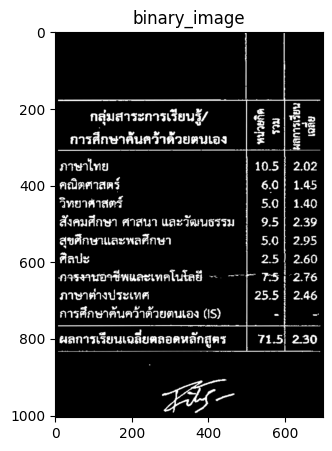

In [319]:

plt.figure(figsize=(5,5))
plt.imshow(cell_2, cmap="gray")
plt.title(f"binary_image")
plt.show()


In [320]:
def find_table_subject_group(cell_img):
    kernel = np.ones((3, 3), np.uint8)
    cell_img_dilated = cv2.dilate(cell_img.copy(), kernel, iterations=1)
    cv2.imwrite(f"{output_folder}/cols/rows/cell_img_dilated.png", cell_img_dilated)
    
    # คำนวณ horizontal projection (ผลรวมของ pixel ในแต่ละแถว)
    horizontal_proj = np.sum(cell_img_dilated, axis=1)
    vertical_proj = np.sum(cell_img_dilated, axis=0)
    
    # ตั้ง threshold สำหรับเลือกเฉพาะแถวที่มี "เส้น"
    horizontal_line_threshold = np.max(horizontal_proj) * 0.9
    vertical_line_threshold = np.max(vertical_proj) * 0.7
    
    # หา indices ของแถวที่มีค่า projection มากกว่าค่า threshold
    row_line_indices = [i for i, value in enumerate(horizontal_proj) if value > horizontal_line_threshold]
    col_line_indices = [i for i, value in enumerate(vertical_proj) if value > vertical_line_threshold]
    
    # รวมกลุ่ม indices ที่ติดกัน (ต้องมีฟังก์ชัน group_indices ที่คุณนิยามไว้แล้ว)
    groups_row = group_indices(row_line_indices, gap=1)
    groups_col = group_indices(col_line_indices, gap=1)

    # สำหรับแต่ละกลุ่ม หา index กลางเป็นตำแหน่งของเส้น
    # แต่แทนที่จะใช้ความหนาแน่น เราจะใช้ความยาวของแต่ละกลุ่ม (จำนวน index ในกลุ่ม)
    groups_row_with_length = [(group, len(group)) for group in groups_row]
    groups_col_with_length = [(group, len(group)) for group in groups_col]

    # เรียงลำดับกลุ่มจากความยาวมากไปหาน้อย
    groups_row_with_length.sort(key=lambda x: x[1], reverse=True)
    groups_col_with_length.sort(key=lambda x: x[1], reverse=True)
    
    # เลือกเฉพาะกลุ่มที่มีความยาวมากที่สุด
    top_groups_row = groups_row_with_length[:4]
    top_groups_col = groups_col_with_length[:2]

    # คำนวณตำแหน่งเส้นโดยการหาค่าเฉลี่ยของแต่ละกลุ่ม แล้วเรียงลำดับจากบนลงล่าง
    row_lines = [int(np.mean(group)) for group, _ in top_groups_row]
    col_lines = [int(np.mean(group)) for group, _ in top_groups_col]
    row_lines.sort()
    col_lines.sort()
    
    print("ตำแหน่งของเส้นแถวที่ตรวจจับได้:", row_lines)
    print("ตำแหน่งของเส้นคอลัมน์ที่ตรวจจับได้:", col_lines)
    
    # --- สร้าง Mask จากเส้นแถว ---
    mask_row = np.zeros_like(cell_img_dilated)
    mask_col = np.zeros_like(cell_img_dilated)
    
    # วาดเส้นแถวลงใน mask (เส้นแนวนอน)
    for y in row_lines:
        cv2.line(mask_row, (0, y), (mask_row.shape[1]-1, y), 255, thickness=10)
    cv2.imwrite(f"{output_folder}/cols/rows/row_lines_mask.png", mask_row)

    # วาดเส้นคอลัมน์ลงใน mask (เส้นแนวตั้ง)
    for x in col_lines:
        cv2.line(mask_col, (x, 0), (x, mask_col.shape[0]-1), 255, thickness=10)
    cv2.imwrite(f"{output_folder}/cols/rows/col_lines_mask.png", mask_col)
    
    # --- ใช้ cv2.bitwise_and เพื่อลบเส้นแถวออกจากภาพ ---
    mask_row_inv = cv2.bitwise_not(mask_row)
    img_no_lines_row = cv2.bitwise_and(cell_img, cell_img, mask=mask_row_inv)
    cv2.imwrite(f"{output_folder}/cols/rows/table_no_lines_bitwise_row.png", img_no_lines_row)

    # --- ใช้ cv2.bitwise_and เพื่อลบเส้นแนวตั้งออกจากภาพ ---
    mask_col_inv = cv2.bitwise_not(mask_col)
    img_no_lines_col = cv2.bitwise_and(cell_img, cell_img, mask=mask_col_inv)
    cv2.imwrite(f"{output_folder}/cols/rows/table_no_lines_bitwise_col.png", img_no_lines_col)

    # --- ใช้ cv2.bitwise_and เพื่อลบเส้นแนวตั้งและแนวนอนออกจากภาพ ---
    combined_mask = cv2.bitwise_or(mask_row, mask_col)
    combined_mask_inv = cv2.bitwise_not(combined_mask)
    img_no_lines_row_col = cv2.bitwise_and(cell_img, cell_img, mask=combined_mask_inv)
    
    cv2.imwrite(f"{output_folder}/cols/rows/img_no_lines_row_col.png", img_no_lines_row_col)


    # --- Crop ภาพโดยใช้พิกัดของเส้นที่ตรวจจับได้ ---
    cropped_row_segments = []
    # loop จะทำงานจากเส้นที่ 1 ถึงเส้นที่ n-1 (crop ภาพระหว่างเส้นที่ i และ i+1)\

    for i in range(len(row_lines) - 1):
        y_start = row_lines[i]
        y_end = row_lines[i+1]
        cropped = img_no_lines_row_col[y_start:y_end, :]  # crop ทุกคอลัมน์ในช่วงแถวที่กำหนด
        cropped_row_segments.append(cropped)
        cv2.imwrite(f"{output_folder}/cols/rows/Cropped Segment {i+1}.png", cropped)



    for idx, row_img in enumerate(cropped_row_segments[1:]):
        x_start = col_lines[0]
        x_end = col_lines[1]
        if(idx == 0):
            department_credits_img = row_img[:, x_start:x_end]
            department_academic_results_img = row_img[:, x_end:]
            cv2.imwrite(f"{output_folder}/cols/rows/department_credits.png", department_credits_img)
            cv2.imwrite(f"{output_folder}/cols/rows/department_academic_results.png", department_academic_results_img)
        else:
            sum_department_credits_img = row_img[:, x_start:x_end]
            gpa_img = row_img[:, x_end:]
            cv2.imwrite(f"{output_folder}/cols/rows/sum_department_credits.png", sum_department_credits_img)
            cv2.imwrite(f"{output_folder}/cols/rows/gpa.png", gpa_img)

    return department_credits_img, department_academic_results_img, sum_department_credits_img, gpa_img

department_credits_img, department_academic_results_img, sum_department_credits_img, gpa_img = find_table_subject_group(cell_2)


ตำแหน่งของเส้นแถวที่ตรวจจับได้: [177, 308, 766, 833]
ตำแหน่งของเส้นคอลัมน์ที่ตรวจจับได้: [499, 598]


### หากลุ่มข้อความของตาราง subject_group

In [321]:
def detect_text_subject_group(cell_img):
    debug = False
    texts = []

    kernel_open = np.ones((3, 3), np.uint8)
    remove_noise = cv2.morphologyEx(cell_img, cv2.MORPH_OPEN, kernel_open, iterations=1)

    if debug == True:
        plt.figure(figsize=(5,5))
        plt.imshow(remove_noise, cmap="gray")
        plt.title(f"remove_noise")
        plt.show()

    kernel = np.ones((3, 8), np.uint8)
    dilate_img = cv2.dilate(remove_noise, kernel, iterations=2)
    rgb_image = cv2.cvtColor(cell_img.copy(), cv2.COLOR_GRAY2RGB)

    if debug == True:
        plt.figure(figsize=(5,5))
        plt.imshow(dilate_img, cmap="gray")
        plt.title(f"dilate_img")
        plt.show()

    # ใช้ Connected Component Analysis
    num_labels, labels, stats, centroids = cv2.connectedComponentsWithStats(dilate_img, connectivity=8)
    text_stats = stats[1:]
    sorted_indices = np.argsort(text_stats[:, 1])  # จัดเรียงตามค่า y (คอลัมน์ที่ 1)
    sorted_stats = text_stats[sorted_indices]
    
    # ใช้ Boolean Indexing เพื่อเอา noise ออก 
    sorted_stats = sorted_stats[sorted_stats[:, 4] >= 800]

    for idx, stats in enumerate(sorted_stats): # เก็บภาพกลุม
        x, y, w, h, area = stats
        #print(f"CCA #{idx}: bounding box = (x={x}, y={y}, w={w}, h={h}, area={area})")
        crop_img = cell_img[y:y+h, x:x+w]
        texts.append(crop_img)

    return texts

texts_department_credits = detect_text_subject_group(department_credits_img)
texts_department_academic_results = detect_text_subject_group(department_academic_results_img)

texts_sum_department_credits = detect_text_subject_group(sum_department_credits_img)
texts_gpa = detect_text_subject_group(gpa_img)

In [ ]:
# ทดสอบดูรูป
for idx, text in enumerate(texts_department_credits):
    print(f"text {idx+1}")
    plt.figure(figsize=(2,2))
    plt.imshow(text, cmap="gray")
    plt.title(f"text {idx+1}")
    plt.show()

## ทำนาย

In [322]:
def predict_text_subject_group(text_group):

    custom_config = r'--oem 3 --psm 7 tessedit_char_whitelist=0123456789.'
    custom_lang = 'eng'

    text_box = []
    for idx, text in enumerate(text_group):
        if not np.any(text):
            print("เข้าเงื่อนไข")
            text = "-"
        else:
            text = pytesseract.image_to_string(text, config=custom_config, lang=custom_lang)

            '''
            plt.figure(figsize=(4,4))
            plt.imshow(text, cmap="gray")
            plt.title(f"sub text {idx_sub+1}")
            plt.show()
            '''
            text_cleaned = text.replace("\n", "")  # ลบ \n ออก
        text_box.append(text_cleaned)

    return text_box

text_box_department_credits = predict_text_subject_group(texts_department_credits)
text_box_department_academic_results = predict_text_subject_group(texts_department_academic_results)
text_box_sum_department_credits = predict_text_subject_group(texts_sum_department_credits)
text_box_gpa = predict_text_subject_group(texts_gpa)

In [323]:
def show_information(array):
    for idx, data in enumerate(array):
        print(data)

#show_information(text_box_department_credits)
#show_information(text_box_department_academic_results)
#show_information(text_box_sum_department_credits)
#show_information(text_box_gpa)
print(text_box_department_credits)
print(text_box_department_academic_results)
print(text_box_sum_department_credits)
print(text_box_gpa)

['10.5', '6.0', '5.0', '05', '5.0', '25', 'TS', '25.5']
['2.02', '1.45', '1.40', '2.39', '2.95', '2.60', '“2.76', '2.46']
['715']
['230']
